In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical

class PneumoniaDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', shuffle=True, num_classes=2):
        """
        Custom data generator for Pneumonia dataset (Normal vs Pneumonia)
        root_dir: path to dataset (e.g., '../input/chest-xray-pneumonia/chest_xray')
        mode: 'train', 'val', or 'test'
        """
        self.root_dir = os.path.join(root_dir, mode)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.mode = mode
        self.class_names = ['NORMAL', 'PNEUMONIA']

        self.data = self._load_data()
        self.on_epoch_end()

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in os.listdir(class_dir):
                img_path = os.path.join(class_dir, fname)
                data.append((img_path, label_idx))
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index * self.batch_size:(index + 1) * self.batch_size]
        images, labels = [], []

        for img_path, label in batch_data:
            # Load and resize image
            img = cv2.imread(img_path)  # BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0

            images.append(img)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)


2025-10-15 17:19:56.592897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760548796.791430      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760548796.850324      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ✅ Use the Pneumonia dataset path instead of the COVID dataset
dataset_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

# ✅ Use the adapted PneumoniaDataGenerator class (binary classification)
train_gen = PneumoniaDataGenerator(
    root_dir=dataset_path,
    mode='train',
    batch_size=32,
    img_size=(224, 224)
)

val_gen = PneumoniaDataGenerator(
    root_dir=dataset_path,
    mode='val',
    batch_size=32,
    img_size=(224, 224)
)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Reshape,
                                     LSTM, Dense, Bidirectional)

def build_cnn_lstm_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # CNN Backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)   # 112x112
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 56x56
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 28x28
    x = MaxPooling2D((2, 2))(x)   # 14x14

    # Flatten spatial dimensions to sequence for LSTM
    x = Reshape((14 * 14, 128))(x)

    # LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    # Output layer (2 classes: Normal / Pneumonia)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# ✅ Build the adapted model
model = build_cnn_lstm_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1760548809.855346      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760548809.856090      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,322 (751.26 KB)

 Trainable params: 192,322 (751.26 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760548817.291037      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 533ms/step - accuracy: 0.7645 - loss: 0.4828 - val_accuracy: 0.6250 - val_loss: 0.6427
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - accuracy: 0.8868 - loss: 0.2645 - val_accuracy: 0.7500 - val_loss: 0.4337
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.9163 - loss: 0.1995 - val_accuracy: 0.8125 - val_loss: 0.4199
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.9204 - loss: 0.1807 - val_accuracy: 0.9375 - val_loss: 0.2999
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 329ms/step - accuracy: 0.9400 - loss: 0.1425 - val_accuracy: 0.8750 - val_loss: 0.3486
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9403 - loss: 0.1316 - val_accuracy: 0.8750 - val_loss: 0.2331
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9542 - loss: 0.1141 - val_accuracy: 0.8750 - val_loss: 0.3130
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 332ms/step - accuracy: 0.9647 - loss: 0.0891 - val

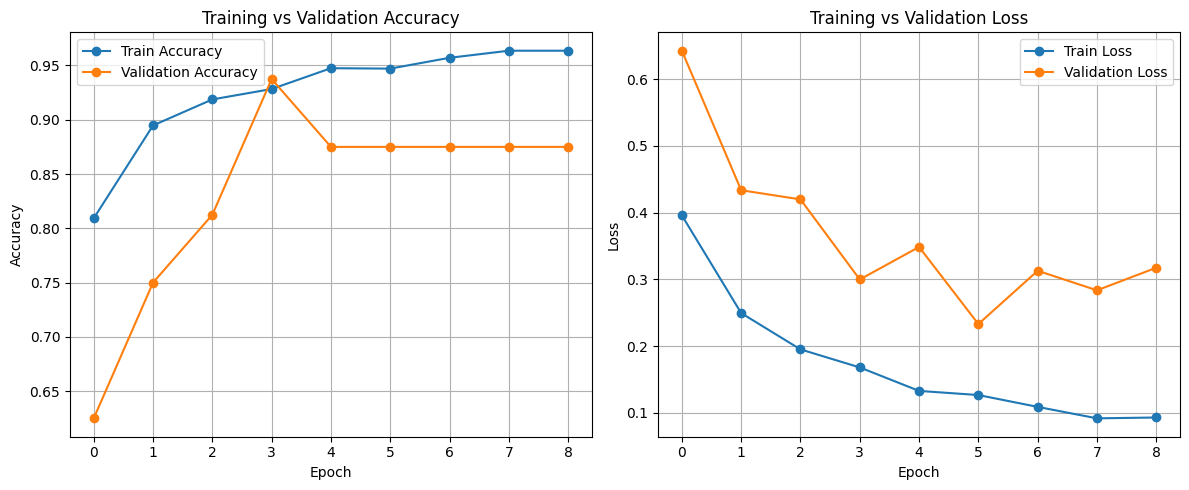


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.88      0.88      0.88         8
   PNEUMONIA       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



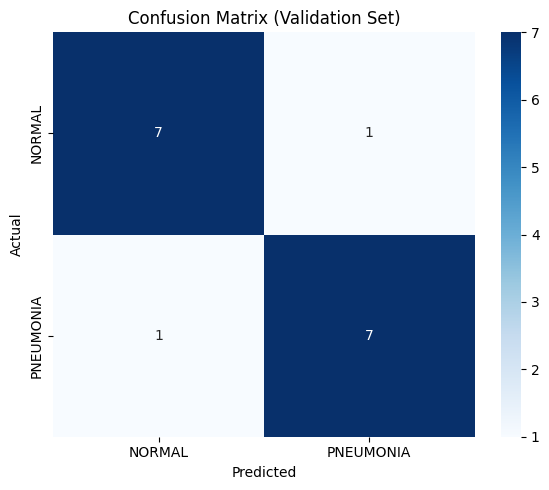

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# ✅ Plot training curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_history(history)


# ✅ Classification report + confusion matrix on validation set
y_true, y_pred = [], []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use generator's class names
class_names = val_gen.class_names

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()


In [7]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# -----------------------------
# Data Generator Class
# -----------------------------
class PneumoniaDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', shuffle=True, num_classes=2):
        self.root_dir = os.path.join(root_dir, mode)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.class_names = ['NORMAL', 'PNEUMONIA']

        print(f"\n[INFO] Loading {mode} dataset...")
        self.data = self._load_data()
        self.on_epoch_end()
        print(f"[INFO] {mode.upper()} set: {len(self.data)} samples\n")

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in os.listdir(class_dir):
                data.append((os.path.join(class_dir, fname), label_idx))
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = [], []

        for img_path, label in batch_data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0
            images.append(img)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# CNN Model Definition
# -----------------------------
def build_vanilla_cnn(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# -----------------------------
# Training
# -----------------------------
if __name__ == "__main__":
    root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

    train_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='train', batch_size=32)
    val_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='val', batch_size=32)

    model = build_vanilla_cnn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print("\n[INFO] Starting training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)



[INFO] Loading train dataset...
[INFO] TRAIN set: 5216 samples


[INFO] Loading val dataset...
[INFO] VAL set: 16 samples



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,690 (49.36 MB)

 Trainable params: 12,938,690 (49.36 MB)

 Non-trainable params: 0 (0.00 B)


[INFO] Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760549348.778161      65 service.cc:148] XLA service 0x79d778579e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760549348.779010      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760549348.779035      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/163 ━━━━━━━━━━━━━━━━━━━━ 20:47 8s/step - accuracy: 0.6250 - loss: 0.6881

I0000 00:00:1760549353.762246      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 332ms/step - accuracy: 0.8557 - loss: 0.4483 - val_accuracy: 0.8125 - val_loss: 0.4375
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.9623 - loss: 0.1005 - val_accuracy: 0.6250 - val_loss: 1.1415
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.9676 - loss: 0.0847 - val_accuracy: 0.8750 - val_loss: 0.2024
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 327ms/step - accuracy: 0.9777 - loss: 0.0594 - val_accuracy: 0.6875 - val_loss: 0.7126
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 336ms/step - accuracy: 0.9841 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.0771
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 335ms/step - accuracy: 0.9883 - loss: 0.0342 - val_accuracy: 0.9375 - val_loss: 0.0886
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.9848 - loss: 0.0358 - val_accuracy: 0.7500 - val_loss: 0.7169
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 331ms/step - accuracy: 0.9904 - loss: 0.0269 - val

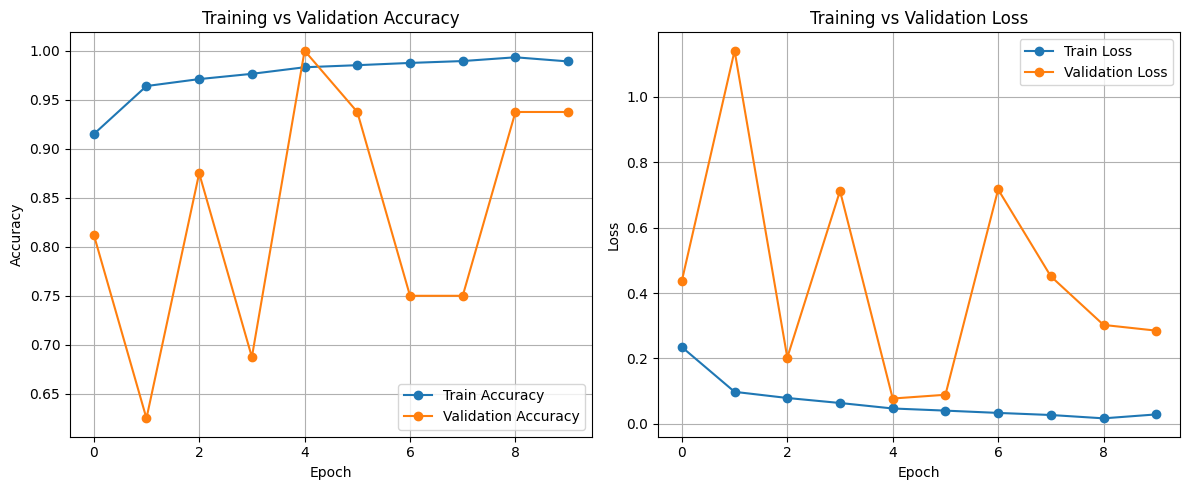


Classification Report:

              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



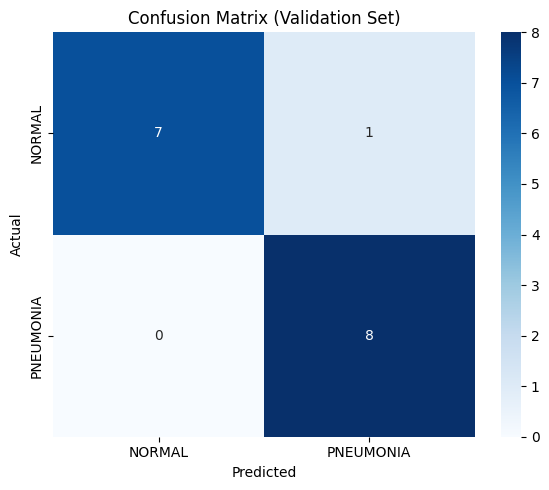

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# -----------------------------
# Plot training curves
# -----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_history(history)

# -----------------------------
# Classification report & confusion matrix on validation set
# -----------------------------
y_true, y_pred = [], []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use generator's class names
class_names = val_gen.class_names  # ['NORMAL', 'PNEUMONIA']

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()


In [9]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dropout, Dense

# -----------------------------
# Data Generator Class
# -----------------------------
class PneumoniaDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', shuffle=True, num_classes=2):
        self.root_dir = os.path.join(root_dir, mode)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.class_names = ['NORMAL', 'PNEUMONIA']

        print(f"\n[INFO] Loading {mode} dataset...")
        self.data = self._load_data()
        self.on_epoch_end()
        print(f"[INFO] {mode.upper()} set: {len(self.data)} samples\n")

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in os.listdir(class_dir):
                data.append((os.path.join(class_dir, fname), label_idx))
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = [], []

        for img_path, label in batch_data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0
            images.append(img)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# CNN-LSTM Model Definition
# -----------------------------
def build_cnn_lstm_model(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # CNN Backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)   # 112x112
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 56x56
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)   # 28x28
    x = MaxPooling2D((2, 2))(x)   # 14x14

    # Flatten spatial dimensions to sequence for LSTM
    x = Reshape((14 * 14, 128))(x)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.5)(x)

    # Output
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# -----------------------------
# Training
# -----------------------------
if __name__ == "__main__":
    root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

    train_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='train', batch_size=32)
    val_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='val', batch_size=32)

    model = build_cnn_lstm_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print("\n[INFO] Starting training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)



[INFO] Loading train dataset...
[INFO] TRAIN set: 5216 samples


[INFO] Loading val dataset...
[INFO] VAL set: 16 samples



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,322 (751.26 KB)

 Trainable params: 192,322 (751.26 KB)

 Non-trainable params: 0 (0.00 B)


[INFO] Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 327ms/step - accuracy: 0.7544 - loss: 0.4824 - val_accuracy: 0.7500 - val_loss: 0.4331
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.8932 - loss: 0.2404 - val_accuracy: 0.8750 - val_loss: 0.2723
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.9156 - loss: 0.2051 - val_accuracy: 0.8750 - val_loss: 0.3173
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.9339 - loss: 0.1716 - val_accuracy: 0.9375 - val_loss: 0.2149
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - accuracy: 0.9450 - loss: 0.1411 - val_accuracy: 0.9375 - val_loss: 0.2057
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9519 - loss: 0.1284 - val_accuracy: 0.9375 - val_loss: 0.1677
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 326ms/step - accuracy: 0.9578 - loss: 0.1046 - val_accuracy: 0.9375 - val_loss: 0.2095
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.9645 - loss: 0

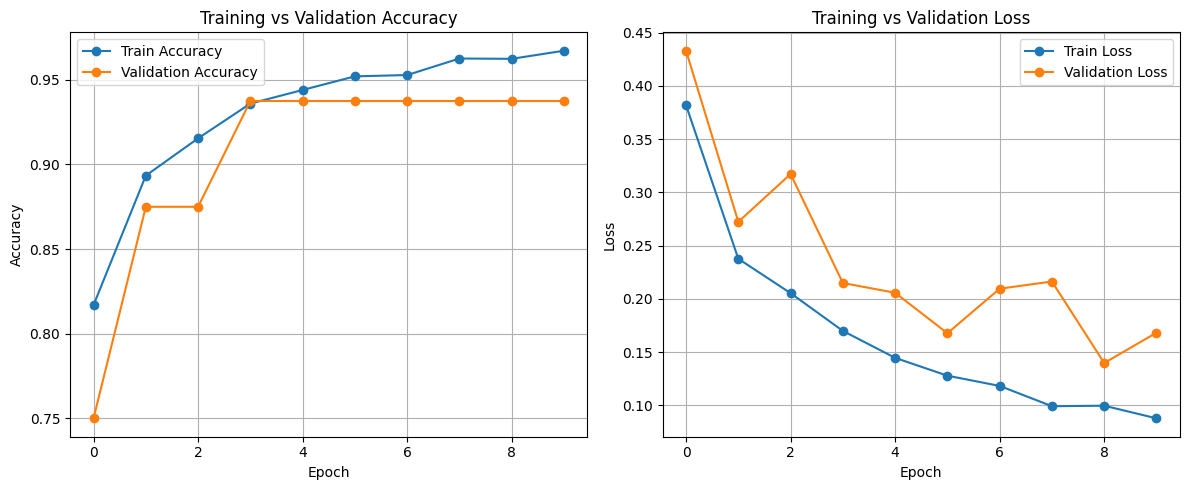


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.89      1.00      0.94         8
   PNEUMONIA       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



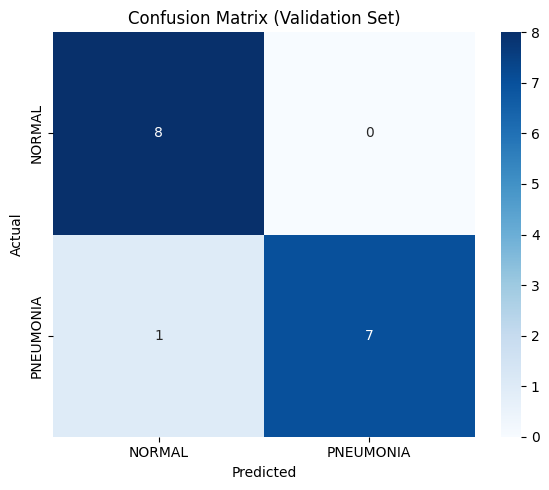

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# -----------------------------
# Plot training curves
# -----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_history(history)

# -----------------------------
# Classification report & confusion matrix on validation set
# -----------------------------
y_true, y_pred = [], []

# Iterate over validation generator
for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use generator's class names
class_names = val_gen.class_names  # ['NORMAL', 'PNEUMONIA']

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()


In [11]:
import os
import cv2
import numpy as np
import random
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -----------------------------
# Data Generator Class
# -----------------------------
class PneumoniaDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', shuffle=True, num_classes=2):
        self.root_dir = os.path.join(root_dir, mode)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.class_names = ['NORMAL', 'PNEUMONIA']

        print(f"\n[INFO] Loading {mode} dataset...")
        self.data = self._load_data()
        self.on_epoch_end()
        print(f"[INFO] {mode.upper()} set: {len(self.data)} samples\n")

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in os.listdir(class_dir):
                data.append((os.path.join(class_dir, fname), label_idx))
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = [], []

        for img_path, label in batch_data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = preprocess_input(img.astype("float32"))  # EfficientNet preprocessing
            images.append(img)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# Pre-trained Model Definition
# -----------------------------
def build_pretrained_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# -----------------------------
# Training
# -----------------------------
if __name__ == "__main__":
    root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

    train_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='train', batch_size=32)
    val_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='val', batch_size=32)

    model = build_pretrained_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print("\n[INFO] Starting training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)



[INFO] Loading train dataset...
[INFO] TRAIN set: 5216 samples


[INFO] Loading val dataset...
[INFO] VAL set: 16 samples

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


[INFO] Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 368ms/step - accuracy: 0.7908 - loss: 0.4500 - val_accuracy: 0.8750 - val_loss: 0.3788
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.9133 - loss: 0.1973 - val_accuracy: 0.8750 - val_loss: 0.3166
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9340 - loss: 0.1680 - val_accuracy: 0.8750 - val_loss: 0.2641
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9366 - loss: 0.1602 - val_accuracy: 0.9375 - val_loss: 0.1794
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.9460 - loss: 0.1412 - val_accuracy: 0.9375 - val_loss: 0.2197
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - accuracy: 0.9436 - loss: 0.1442 - val_accuracy: 0.9375 - val_loss: 0.2372
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 310ms/step - accuracy: 0.9466 - loss: 0.1307 - val_accuracy: 0.9375 - val_loss: 0.1697
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 313ms/step - accuracy: 0.9425 - loss: 0

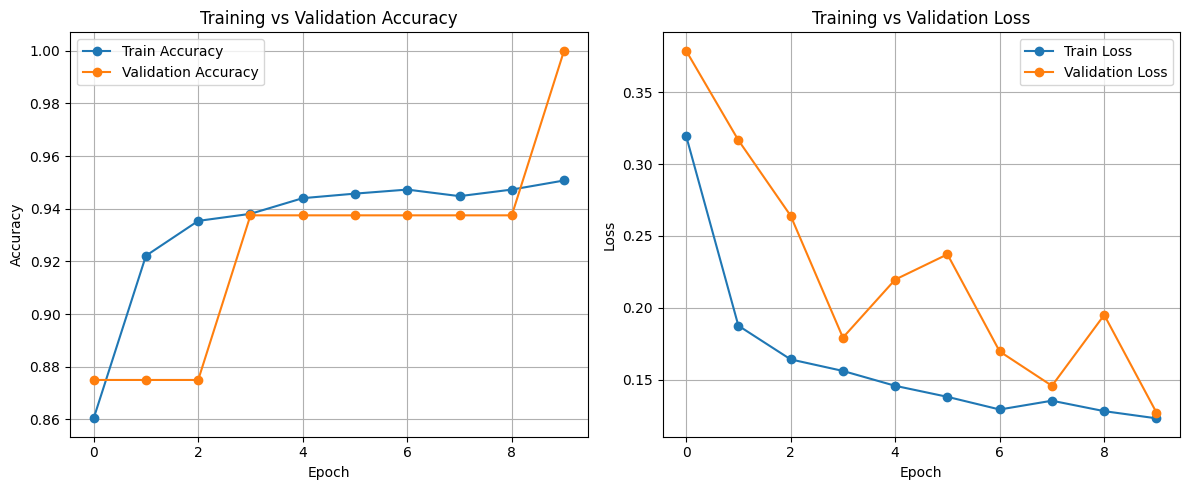


Classification Report:

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



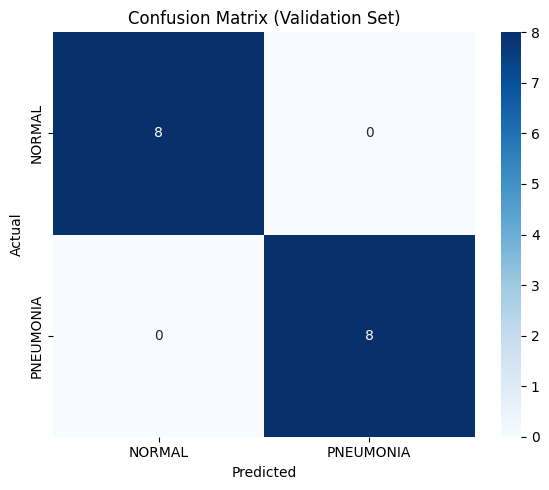

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# -----------------------------
# Plot training curves
# -----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_history(history)

# -----------------------------
# Classification report & confusion matrix on validation set
# -----------------------------
y_true, y_pred = [], []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    
    # Ensure preprocessing matches pre-trained model
    X_batch = preprocess_input(X_batch)
    
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use generator's class names
class_names = val_gen.class_names  # ['NORMAL', 'PNEUMONIA']

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 615ms/step - accuracy: 0.5722 - loss: 0.7433 - val_accuracy: 0.5000 - val_loss: 0.7362
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 575ms/step - accuracy: 0.7956 - loss: 0.4370 - val_accuracy: 0.6250 - val_loss: 0.6031
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 577ms/step - accuracy: 0.8319 - loss: 0.3534 - val_accuracy: 0.8125 - val_loss: 0.5227
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.8721 - loss: 0.2896 - val_accuracy: 0.8125 - val_loss: 0.4741
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 576ms/step - accuracy: 0.8769 - loss: 0.2830 - val_accuracy: 0.8125 - val_loss: 0.4928
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.8787 - loss: 0.2599 - val_accuracy: 0.8125 - val_loss: 0.4447
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.8942 - loss: 0.2480 - val_accuracy: 0.8125 - val_loss: 0.4212
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 574ms/step - accuracy: 0.8972 - loss: 

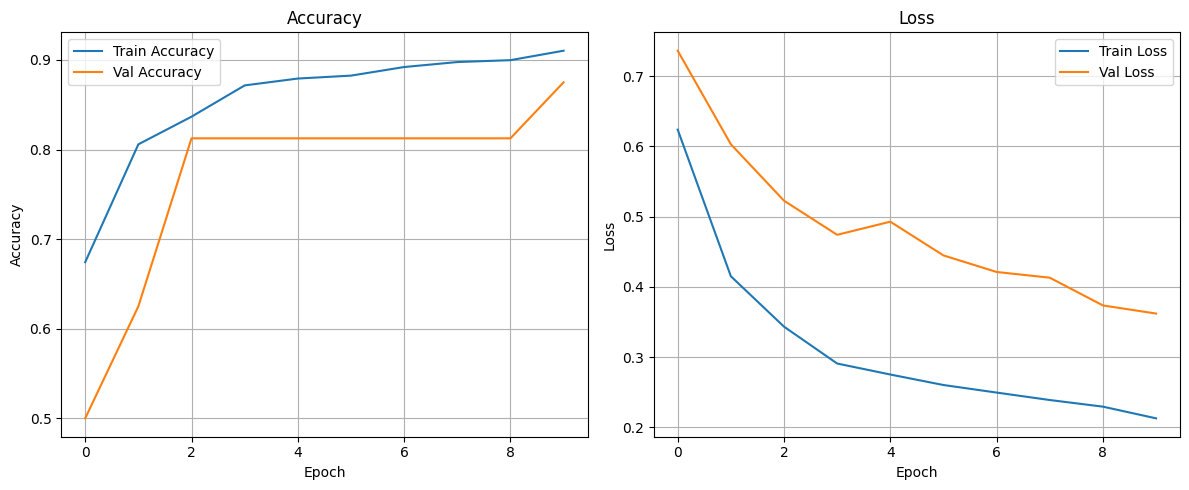

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       1.00      0.75      0.86         8
   PNEUMONIA       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



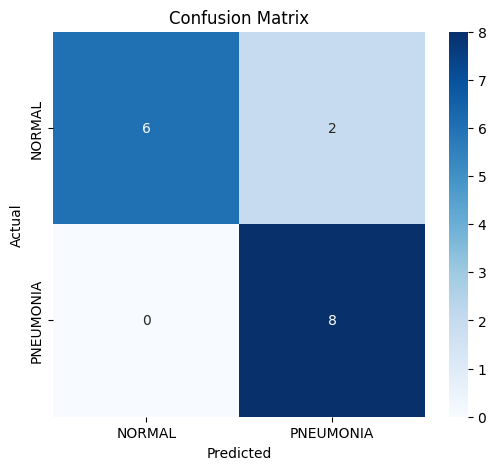

In [13]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# -----------------------------
# Paths
# -----------------------------
root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# -----------------------------
# Image Data Generators
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=None,  # We will apply EfficientNet preprocessing later
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=None)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build Pre-trained Model
# -----------------------------
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# -----------------------------
# Training
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# -----------------------------
# Plot Training History
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.title('Loss')

plt.tight_layout()
plt.show()

# -----------------------------
# Evaluation
# -----------------------------
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()



[INFO] Loading train dataset...
[INFO] TRAIN set: 5216 samples


[INFO] Loading val dataset...
[INFO] VAL set: 16 samples

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_Pneumonia_2Class"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_head (BatchNormalization)    │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_head (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_256 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_mid (BatchNormalization)     │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_mid (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,602 (56.65 MB)

 Trainable params: 133,378 (521.01 KB)

 Non-trainable params: 14,716,224 (56.14 MB)


[INFO] Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 389ms/step - accuracy: 0.8545 - loss: 0.4576 - val_accuracy: 0.9375 - val_loss: 0.1336
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.9434 - loss: 0.1961 - val_accuracy: 0.8750 - val_loss: 0.3130
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.9586 - loss: 0.1523 - val_accuracy: 0.8750 - val_loss: 0.4188
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.9526 - loss: 0.1681 - val_accuracy: 0.8750 - val_loss: 0.2894
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 343ms/step - accuracy: 0.9668 - loss: 0.1379 - val_accuracy: 0.8750 - val_loss: 0.2826
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 340ms/step - accuracy: 0.9569 - loss: 0.1452 - val_accuracy: 0.8750 - val_loss: 0.2971
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 340ms/step - accuracy: 0.9626 - loss: 0.1267 - val_accuracy: 0.8750 - val_loss: 0.1926
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9672 - loss: 0

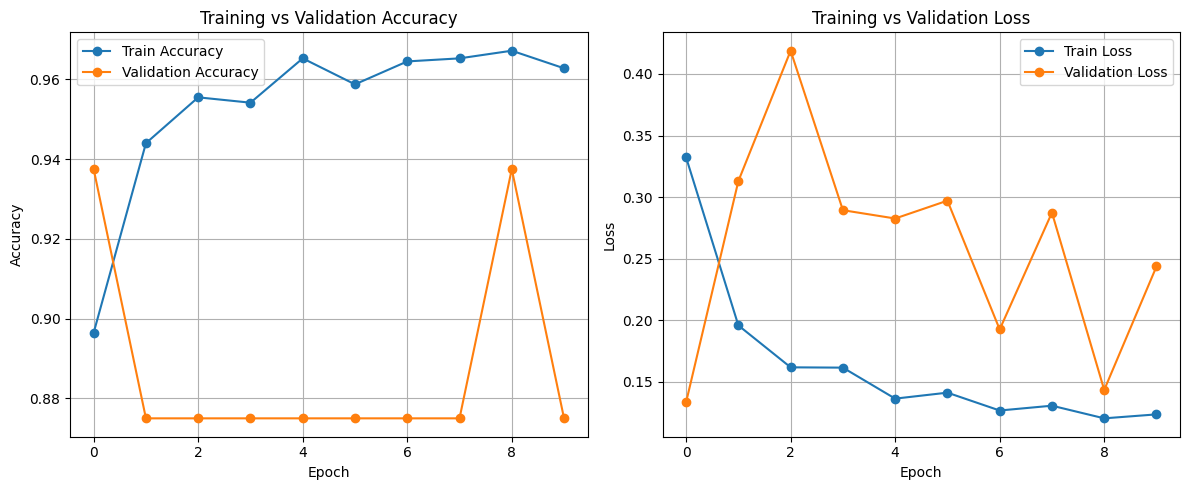


Classification Report:

              precision    recall  f1-score   support

      NORMAL       1.00      0.75      0.86         8
   PNEUMONIA       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



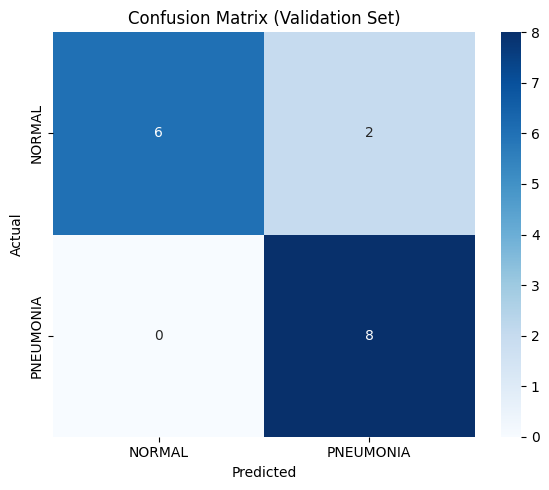

In [14]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     GlobalAveragePooling2D, BatchNormalization, Lambda)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# -----------------------------
# Data Generator Class
# -----------------------------
class PneumoniaDataGenerator(Sequence):
    def __init__(self, root_dir, batch_size=32, img_size=(224, 224), mode='train', shuffle=True, num_classes=2):
        self.root_dir = os.path.join(root_dir, mode)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.class_names = ['NORMAL', 'PNEUMONIA']

        print(f"\n[INFO] Loading {mode} dataset...")
        self.data = self._load_data()
        self.on_epoch_end()
        print(f"[INFO] {mode.upper()} set: {len(self.data)} samples\n")

    def _load_data(self):
        data = []
        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            for fname in os.listdir(class_dir):
                data.append((os.path.join(class_dir, fname), label_idx))
        return data

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = [], []

        for img_path, label in batch_data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype("float32") / 255.0   # your pipeline rescales to 0..1
            images.append(img)
            labels.append(label)

        images = np.array(images)
        labels = to_categorical(labels, num_classes=self.num_classes)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)

# -----------------------------
# VGG16 Transfer-Learning Model (drop-in replacement)
# -----------------------------
def build_vgg16_transfer(input_shape=(224, 224, 3), num_classes=2, l2_reg=1e-4,
                         dropout_top=0.5, dropout_mid=0.4, freeze_base=True):
    """
    Replaces the vanilla CNN with a VGG16(ImageNet) backbone + lightweight head.
    Keeps 2-class softmax output so you don't need to change your loss/labels.
    """
    inputs = Input(shape=input_shape, name="image")

    # Your generator outputs 0..1 floats. VGG16 preprocess expects 0..255 then mean subtraction.
    x = Lambda(lambda t: preprocess_input(t * 255.0), name="vgg16_preprocess")(inputs)

    # Base VGG16 (no top), pretrained on ImageNet
    base = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = not freeze_base  # freeze feature extractor by default

    x = base(x, training=not freeze_base)
    x = GlobalAveragePooling2D(name="gap")(x)

    # Lightweight classification head with regularization & dropout
    x = BatchNormalization(name="bn_head")(x)
    x = Dropout(dropout_top, name="dropout_head")(x)
    x = Dense(256, activation="relu",
              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
              name="fc_256")(x)
    x = BatchNormalization(name="bn_mid")(x)
    x = Dropout(dropout_mid, name="dropout_mid")(x)

    # Keep 2-unit softmax to match your existing one-hot labels and categorical_crossentropy
    outputs = Dense(num_classes, activation="softmax", name="pred")(x)

    model = Model(inputs, outputs, name="VGG16_Pneumonia_2Class")
    return model

# -----------------------------
# Training
# -----------------------------
if __name__ == "__main__":
    root_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

    train_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='train', batch_size=32)
    val_gen = PneumoniaDataGenerator(root_dir=root_dir, mode='val', batch_size=32)

    # --- DROP-IN CHANGE: swap the model builder call ---
    model = build_vgg16_transfer(input_shape=(224, 224, 3), num_classes=2, freeze_base=True)

    # Keep your original compile to avoid touching the training code
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    print("\n[INFO] Starting training...")
    history = model.fit(train_gen, validation_data=val_gen, epochs=10)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# -----------------------------
# Plot training curves
# -----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_history(history)

# -----------------------------
# Classification report & confusion matrix on validation set
# -----------------------------
y_true, y_pred = [], []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use generator's class names
class_names = val_gen.class_names  # ['NORMAL', 'PNEUMONIA']

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()
